In [1]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)

import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import display, HTML

import requests
import pickle

In [2]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow", "not "]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))

In [3]:
# a function that tries to fix a location id, leaves non-waypoint labels alone in case they are in the gps data
# fixes the leading zeros problem WR004 = WR0004
def clean_loc_id(id):
    try:
        waypoint_search = re.search('((?:WR|WA)(?:CS|))([0-9]+)', id, re.IGNORECASE)

        if waypoint_search:        
            waypoint_type = waypoint_search.group(1)
            waypoint_num = waypoint_search.group(2)

            return f"{waypoint_type}{int(waypoint_num):04}"
    except:
        return id
    return id
assert(clean_loc_id("WR004") == "WR0004")

In [4]:
# functions for finding the last positive result and last negative result
def last_pos(loc_id, date):
    last_pos_date = data[(data.loc_id == loc_id) & (data.status==1) & (data.date < date)].date.max()
    if type(last_pos_date) == float:
        return 1000
    return (date - last_pos_date).days
    
def last_neg(loc_id, date):
    last_neg_date = data[(data.loc_id == loc_id) & (data.status==0) & (data.date < date)].date.max()    
    if type(last_neg_date) == float:
        return 1000
    return (date - last_neg_date).days

In [5]:
# create a lat, lon, and name dictionaries keyed on loc_ids 
waypoints = []
for path in glob.glob("gps/*.gpx"):
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    waypoints += (gpx.waypoints)
    
lat = {clean_loc_id(wp.name):wp.latitude for wp in waypoints}
lon = {clean_loc_id(wp.name):wp.longitude for wp in waypoints}
name = {clean_loc_id(wp.name):wp.description for wp in waypoints}

In [6]:
waypoints

[GPXWaypoint(41.158167, -122.29788, elevation=751.0, name='KettlebellyTR', description='Kettlebelly Trail junction', symbol='Trail Head'),
 GPXWaypoint(41.164, -122.310161, elevation=764.3, name='FernSpringsTR', description='Fern Springs trail junction', symbol='Trail Head'),
 GPXWaypoint(41.16411, -122.310119, elevation=763.5, name='FernSprings', description='Fern Springs', symbol='Water Source'),
 GPXWaypoint(41.162298, -122.312262, elevation=804.3, name='RootCreekTR', description='Root Creek trail junction', symbol='Trail Head'),
 GPXWaypoint(41.161274, -122.312177, elevation=803.1, name='VistaPointTR', description='Vista Point trail junction', symbol='Trail Head'),
 GPXWaypoint(41.16018, -122.312608, elevation=814.3, name='CragsTR', description='Crags Trail junction', symbol='Trail Head'),
 GPXWaypoint(41.158052, -122.320655, elevation=861.9, name='BobsHatTR', description="Bob's Hat trail junction", symbol='Trail Head'),
 GPXWaypoint(41.162168, -122.327274, elevation=889.0, name='C

In [7]:
# a generator for sequentially reading in the data
def data_generator():
    for f in glob.glob("pct_data/*.xlsx"):
        data = pd.read_excel(f).dropna()
        _,cols = data.shape
        if cols == 7:
            data.columns = ["map","mile","loc_id","loc", "description", "date", "user"]
        if cols == 8:
            data.columns = ["map","mile_2","mile","loc_id","loc", "description", "date", "user"]
        yield data

In [8]:
# import and combine data
data = pd.concat(data_generator())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [9]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [10]:
# clean up the lod_ids
data.loc_id = data.loc_id.apply(clean_loc_id)

In [11]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [12]:
# create lat and lon columns
data["lat"] = data["loc_id"].map(lat)
data["lon"] = data["loc_id"].map(lon)

In [13]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["decision"] = data.flowing|data.not_flowing
data["status"] = data.flowing.astype(float)

In [14]:
# remove duplicate entries (ones with the same date and loc_id)
data = data.drop_duplicates(subset=["date","loc_id"])

In [15]:
# remove all data with no decision
data = data[data.decision]

In [16]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.loc_id, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.loc_id, row.date), axis=1)

In [17]:
# drop data with missing coordinates
data = data.dropna(subset=["lat"])

In [18]:
loc_ids = list(data.groupby("loc_id").nunique().sort_values(by="date")[-50:].loc_id.index)

In [19]:
data = data[data.loc_id.isin(loc_ids)]

In [20]:
data.shape

(1124, 17)

In [21]:
try:
    f = open('rain_memo.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    rain_memo = {}

def getRainfall(loc_id, unix_time):
    if (loc_id, unix_time) in rain_memo:
        return rain_memo[(loc_id, unix_time)]
    r = requests.get(f"https://api.darksky.net/forecast/840fdc3fb61acc3d4e904978b5ba8dc5/{lat[loc_id]},{lon[loc_id]},{unix_time}")
    rain = r.json()["daily"]["data"][0]["precipIntensity"]
    rain_memo[(loc_id, unix_time)] = rain
    f = open('rain_memo.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [22]:
rain_memo

{('WRCS0232', 1559520000): 0.0019,
 ('WRCS0232', 1559433600): 0.0005,
 ('WRCS0232', 1559347200): 0,
 ('WRCS0232', 1559260800): 0,
 ('WRCS0232', 1559174400): 0.0002,
 ('WRCS0232', 1528675200): 0,
 ('WRCS0232', 1528588800): 0,
 ('WRCS0232', 1528502400): 0,
 ('WRCS0232', 1528416000): 0,
 ('WRCS0232', 1528329600): 0,
 ('WRCS0232', 1539648000): 0,
 ('WRCS0232', 1539561600): 0.0001,
 ('WRCS0232', 1539475200): 0.034,
 ('WRCS0232', 1539388800): 0.0007,
 ('WRCS0232', 1539302400): 0.0001,
 ('WRCS0232', 1556236800): 0,
 ('WRCS0232', 1556150400): 0,
 ('WRCS0232', 1556064000): 0,
 ('WRCS0232', 1555977600): 0,
 ('WRCS0232', 1555891200): 0,
 ('WRCS0232', 1554854400): 0,
 ('WRCS0232', 1554768000): 0,
 ('WRCS0232', 1554681600): 0,
 ('WRCS0232', 1554595200): 0.0001,
 ('WRCS0232', 1554508800): 0,
 ('WRCS0232', 1524182400): 0,
 ('WRCS0232', 1524096000): 0,
 ('WRCS0232', 1524009600): 0,
 ('WRCS0232', 1523923200): 0,
 ('WRCS0232', 1523836800): 0,
 ('WRCS0232', 1526428800): 0,
 ('WRCS0232', 1526342400): 0,
 

In [23]:
def getRainSum(loc_id, unix_time, n):
    return 24 * sum([getRainfall(loc_id, unix_time - (24*60*60*day)) for day in range(n)])

In [24]:
data["rain_5"] = data.apply(lambda row: getRainSum(row.loc_id, row.unix_time, 5), axis=1)

In [45]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

import time

from matplotlib import cm

In [34]:


out = []
for loc_id in loc_ids:
    inputs = data[data.loc_id == loc_id][["rain_5","last_pos","last_neg"]]
    labels = data[data.loc_id == loc_id]['status']
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0)

    lr = LogisticRegression(C=100, penalty="l1", class_weight="balanced").fit(X_train, y_train)
    svc = SVC(probability=True).fit(X_train, y_train)
    br = BayesianRidge().fit(X_train, y_train)
    rf = RandomForestClassifier(max_depth=5).fit(inputs, labels)

    dummy = DummyClassifier().fit(X_train, y_train)
    dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
    
    print(f'Training score {lr.score(X_train, y_train)}')
    print(f'Training score {svc.score(X_train, y_train)}')
    print(f'Training score {rf.score(X_train, y_train)}')


    print()
    print(f'Test score {lr.score(X_test, y_test)}')
    print(f'Test score {svc.score(X_test, y_test)}')
    print(f'Test score {rf.score(X_test, y_test)}')
    print(f'Dummy score {dummy.score(X_test, y_test)}')
    print(f'Most Frequent score {dummy_majority.score(X_test, y_test)}')
    
    prediction = rf.predict_proba([getRainSum(loc_id, int(time.time()), 5), ])
    out.append({'lat': lat[loc_id], 'lon': lon[loc_id], 'name': name[loc_id], 'prediction':prediction})

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0

In [129]:


inputs = data[["rain_5","last_pos","last_neg","prob_exp"]]
labels = data["status"]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0)
#X_train, X_test, y_train, y_test = inputs[data.loc_id != "WR0004"], inputs[data.loc_id == "WR0004"],labels[data.loc_id != "WR0004"],labels[data.loc_id == "WR0004"]
#X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0, stratify=data.loc_id)

#display(X_test.groupby("loc_id").count())
#display(X_train.groupby("loc_id").count())
#lr = LogisticRegression(C=100, penalty="l1", class_weight="balanced").fit(X_train, y_train)
#svc = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
rf = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

#print(f'Training score {lr.score(X_train, y_train)}')
#print(f'Training score {svc.score(X_train, y_train)}')
print(f'Training score {rf.score(X_train, y_train)}')


print()
#print(f'Test score {lr.score(X_test, y_test)}')
#print(f'Test score {svc.score(X_test, y_test)}')
print(f'Random Forest score {rf.score(X_test, y_test)}')
print(f'Dummy score {dummy.score(X_test, y_test)}')
print(f'Most Frequent score {dummy_majority.score(X_test, y_test)}')

print()
print(f'Random Forest f1 score {f1_score(y_test, rf.predict(X_test))}')
print(f'Dummy f1 score {f1_score(y_test, dummy.predict(X_test))}')
print(f'Most Frequent f1 score {f1_score(y_test, dummy_majority.predict(X_test))}')


Training score 0.9193357058125742

Random Forest score 0.896797153024911
Dummy score 0.7259786476868327
Most Frequent score 0.8718861209964412

Random Forest f1 score 0.9409368635437881
Dummy f1 score 0.8385744234800838
Most Frequent f1 score 0.9315589353612167


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [87]:
out = []
for loc_id in loc_ids:
    now = pd.Timestamp.now().round('1d')
    prediction = rf.predict_proba([[getRainSum(loc_id, int(now.value/10**9), 5), last_pos(loc_id, now), last_neg(loc_id, now)]])
    out.append({'lat': lat[loc_id], 'lon': lon[loc_id], 'name': name[loc_id], 'prediction':prediction[0][1]})
    
f = open('out.pkl', 'wb')
pickle.dump(out, f)
f.close() 

ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 3 

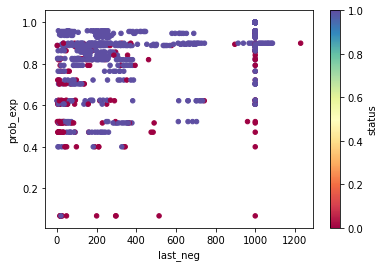

In [82]:
data.plot(kind='scatter',x="last_neg",y="prob_exp",c="status", cmap=cm.get_cmap('Spectral'))

In [83]:
rf.feature_importances_

array([ 0.07411491,  0.30357691,  0.3158566 ,  0.30645157])

In [67]:
data["prob_exp"] = data.apply(lambda row: data[row.loc_id == data.loc_id].status.mean(), axis=1)

In [70]:
data

,date,description,loc,loc_id,map,mile,mile_2,user,unix_time,lat,lon,not_flowing,flowing,decision,status,last_pos,last_neg,rain_5,prob_exp
10,2018-02-17 00:00:00,flowing pretty good.,Creeklet [early spring only]\nBeware of poison oak here.,WR0004,A1,4.4,NaN,Trixie,1518825600,32.608000,-116.498991,False,True,True,1.0,18,999,0.0624,0.900000
13,2018-01-30 00:00:00,dry,Hauser Creek [early spring only],WRCS0015,A2,15.4,NaN,Warner Springs Monty,1517270400,32.661418,-116.545505,True,False,True,0.0,236,6,0.0000,0.470588
17,2018-02-03 00:00:00,dry,Cottonwood Creek Bridge,WR0024,A3,24.1,NaN,Warner Springs Monty,1517616000,32.715239,-116.499008,True,False,True,0.0,281,24,0.0000,0.521739
18,2018-02-03 00:00:00,2/3/18 (warner springs monty) : flowing. crossed on a log.,Cottonwood Creekbed,WR0026,A3,25.5,NaN,Warner Springs Monty,1517616000,32.729263,-116.490416,False,True,True,1.0,8,500,0.0000,0.888889
23,2018-02-03 00:00:00,lots of water.,*Kitchen Creek Falls [2/10 mi NW],KitchenCrFalls,A3,28.5,NaN,Warner Springs Monty,1517616000,32.742984,-116.464639,False,True,True,1.0,239,126,0.0000,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,2018-05-09 00:00:00,5/9/18 (cloud rider) : 1 liter / 30 seconds flow of cold clear water. very shallow and hard to collect without getting dirt.,*Fountainhead Spring,WR0411,D7,411,NaN,Cloud Rider,1525824000,34.380726,-118.027200,False,True,True,1.0,5,1000,0.0000,1.000000
33,2018-03-12 00:00:00,3/12/18 (don) : fair flow/clear.,*Long Canyon Creek ford,WR0038,A5,37.7,NaN,Don,1520812800,32.819298,-116.414038,False,True,True,1.0,6,1000,0.8352,1.000000
58,2018-03-13 00:00:00,3/13/18 (nick) : working great.,**Rodriguez Spur Truck Tr\n[Concrete fire tank visible 75 ft W]\n\n-\nWe are especially interested in water reports about this location. Please send info.,WRCS0068,A9,68.4,NaN,Nick,1520899200,33.050184,-116.524317,False,True,True,1.0,4,36,0.8232,0.606061
85,2018-03-11 00:00:00,3/11/18 (unnamed) : excellent flow.,Agua Caliente Creek\n[near picnic tables],WR0113,B1,112.6,NaN,Unnamed,1520726400,33.295565,-116.638654,False,True,True,1.0,2,85,0.5832,0.793103


In [131]:
data[data.loc_id=="PaynesLake"]

,date,description,loc,loc_id,map,mile,mile_2,user,unix_time,lat,lon,not_flowing,flowing,decision,status,last_pos,last_neg,rain_5,prob_exp
